### Developer Programming Language Analysis by Use and Interest

We are going to use the Stackoverflow annual developer survey to examine developer language preferences over the last five years for developers located in the United States.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Libraries for Embedded Sparklines
import sparklines
import base64
import requests
from time import sleep
from itertools import chain
from io import BytesIO
from datetime import timedelta, date
from IPython.display import display, HTML


%matplotlib inline
%pylab inline

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_seq_items', 100)

# Enables embedded sparklines in pandas
# https://github.com/iiSeymour/sparkline-nb
def sparkline(data, figsize=(4, 0.25), **kwags):
    """
    Returns a HTML image tag containing a base64 encoded sparkline style plot
    """
    data = list(data)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize, **kwags)
    ax.plot(data)
    for k,v in ax.spines.items():
        v.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])    

    plt.plot(len(data) - 1, data[len(data) - 1], 'r.')

    ax.fill_between(range(len(data)), data, len(data)*[min(data)], alpha=0.1)
    
    img = BytesIO()
    plt.savefig(img)
    img.seek(0)
    plt.close()
    return '<img src="data:image/png;base64,{}"/>'.format(base64.b64encode(img.read()).decode())

Populating the interactive namespace from numpy and matplotlib


### Business Questions
1. How have languages being used vs desired changed over time?
2. What are the relatioships between used langauges and desired languages?
3. Which languages are used together?

Analysis of the schemas via schema files and the README in the case of 2016, we can conclude that there is enough relevant information to pull from the last 5 years. We'll concatenate each year's file into a single dataframe for further analysis.

In [2]:
usecols = ['LanguageDesireNextYear' ,'LanguageWorkedWith', 'Country']
df_2020 = pd.read_csv('survey_results_public_2020.csv', usecols = usecols)[usecols]
df_2020['Year'] = 2020

usecols = ['LanguageDesireNextYear' ,'LanguageWorkedWith', 'Country']
df_2019 = pd.read_csv('survey_results_public_2019.csv', usecols = usecols)[usecols]
df_2019['Year'] = 2019
df_2019.columns = df_2020.columns

usecols = ['LanguageDesireNextYear' ,'LanguageWorkedWith', 'Country']
df_2018 = pd.read_csv('survey_results_public_2018.csv', usecols = usecols)[usecols]
df_2018['Year'] = 2018
df_2018.columns = df_2020.columns

usecols = ['WantWorkLanguage' ,'HaveWorkedLanguage', 'Country']
df_2017 = pd.read_csv('survey_results_public_2017.csv', usecols = usecols)[usecols]
df_2017['Year'] = 2017
df_2017.columns = df_2020.columns

usecols = ['tech_want' ,'tech_do', 'country']
df_2016 = pd.read_csv('2016 Stack Overflow Survey Responses.csv', usecols = usecols)[usecols]
df_2016['Year'] = 2016
df_2016.columns = df_2020.columns

df_history = pd.concat([df_2020, df_2019, df_2018, df_2017, df_2016], axis=0)
df_history = df_history[df_history['Country'] == 'United States']
df_history = df_history.rename(columns={'LanguageDesireNextYear':'LanguageInterest', 'LanguageWorkedWith':'LanguageUsed'})
df_history.head()

C:\Users\peter\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (65,66) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,LanguageInterest,LanguageUsed,Country,Year
4,Java;Ruby;Scala,HTML/CSS;Ruby;SQL,United States,2020
7,JavaScript,Python;SQL,United States,2020
13,HTML/CSS;JavaScript;SQL;TypeScript,HTML/CSS;JavaScript;SQL;TypeScript,United States,2020
16,C#;Go;Haskell;HTML/CSS;JavaScript;Python;Ruby;Rust;SQL,C#;HTML/CSS;JavaScript;Python;SQL;VBA,United States,2020
17,HTML/CSS;Perl,Bash/Shell/PowerShell;HTML/CSS;Perl,United States,2020


Let's take a closer look at df_history.

<AxesSubplot:>

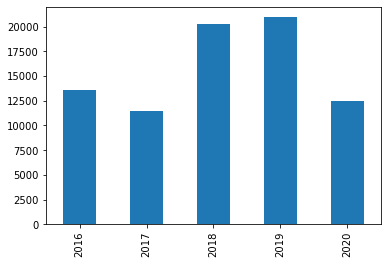

In [3]:
df_history['Year'].value_counts().sort_index().plot(kind='bar')

Since the language used and language desired questions allow for multiple answers, we will setup a function to explode the nested data into separate rows.

In [4]:
def splitAndExplode(df, col, delimiter=','):
# DESCRIPTION - explodes nested info from specified column containing nested data. Creates new rows with new index.
#     Null instances of nested column are thrown out. Also, white space is removed from extracted strings.
# INPUT:
#   - df - dataframe
#   - col - column name that contains nested info
#     Returns new dataframe
# OUTPUT:
#   - new dataframe with nested data exploded to new rows. 

    df = df[df[col].notnull()].copy()
    df[col] = df[col].str.split(delimiter)
    df = df.explode(col, ignore_index=True)
    df[col] = df[col].str.replace(' ','')
    return df

In [5]:
df_lang = df_history.drop(['Country'], axis=1)
df_lang = splitAndExplode(df_lang, 'LanguageInterest', ';')
df_lang = splitAndExplode(df_lang, 'LanguageUsed', ';')

df_lang.shape

(1955391, 3)

In [6]:
pd.pivot_table(df_lang[['LanguageInterest','Year']]
               , index=['LanguageInterest'], columns=['Year']
               , aggfunc=len, fill_value=0).head()

Year,2016,2017,2018,2019,2020
LanguageInterest,,,,,
Android,15221,0,0,0,0
AngularJS,14362,0,0,0,0
Arduino/RaspberryPi,10239,0,0,0,0
Assembly,0,2616,8654,7816,3747
Bash/Shell,0,0,42531,0,0


The sample of the summary above shows that there are a couple issues. Due to the phrasing of the survey question, year 2016 responses include platforms and technologies in addition to languages. Also, a few of the years include similar one-offs. To help standardize the responses between years and in effect drop non-language data, we will drop any language values where the language only occurred in one year and then normalize the results for each year to account for the varying number of respondents in each survey.

In [69]:
lang_year_occurance = df_lang.groupby(['LanguageInterest'])['Year'].nunique()
lang_filter = lang_year_occurance[lang_year_occurance>2].index.tolist()

df_lang = df_lang[df_lang['LanguageInterest'].isin(lang_filter) & df_lang['LanguageUsed'].isin(lang_filter)]
df_lang.shape

(1103497, 3)

Let's crosstab the responses and then then transpose for easier viewing. We will also add a few additional metrics gauge general popularity, variation in popularity, min/max, and average growth. Note that for average growth years without data are not being considered and therefore the mean is being adjusted accordingly to only account for the number of years where growth rate can be calculated without issue (ex. Kotlin only take 2yrs worth of growth rate into account with 2017 being the baseline).

In [115]:
df = pd.crosstab(index=df_lang['Year'], columns=df_lang['LanguageUsed'], normalize='index')

df.columns.name = None
df.index.name = 'LanguageUsed'
df = df.T

df['2016-2020'] = df.values.tolist()
df['2016-2020'] = df['2016-2020'].map(sparkline)
df['Value2016'] = df[2016]
df['Value2020'] = df[2020]
df['4yrDiff'] = df[2020] - df[2016]
df['Rank2016'] = df[2016].rank(ascending=False, method='first')
df['Rank2020'] = df[2020].rank(ascending=False, method='first')
df['RankChange'] = df['Rank2016'] - df['Rank2020']
df = df.iloc[:,5:]
df_ct_used = df.sort_values(by=['Rank2020'])

HTML(df_ct_used.style.format({'Value2016': '{:,.2%}'.format,
                                       'Value2020': '{:,.2%}'.format,
                                       '4yrDiff' : '{:,.2%}'.format})\
                 .background_gradient(cmap='RdBu', subset=['4yrDiff', 'RankChange']).render())

LanguageUsed,2016-2020,Value2016,Value2020,4yrDiff,Rank2016,Rank2020,RankChange
JavaScript,,17.51%,16.05%,-1.46%,1.000000,1.000000,0.000000
SQL,,14.72%,13.64%,-1.09%,2.000000,2.000000,0.000000
Python,,10.12%,12.14%,2.02%,5.000000,3.000000,2.000000
Java,,11.36%,8.61%,-2.75%,3.000000,4.000000,-1.000000
C#,,10.17%,7.81%,-2.36%,4.000000,5.000000,-1.000000
TypeScript,,0.00%,6.45%,6.45%,26.000000,6.000000,20.000000
C++,,6.73%,5.44%,-1.29%,6.000000,7.000000,-1.000000
C,,5.41%,4.74%,-0.67%,8.000000,8.000000,0.000000
PHP,,6.39%,4.21%,-2.18%,7.000000,9.000000,-2.000000
Go,,1.35%,2.96%,1.62%,14.000000,10.000000,4.000000


In [118]:
df = pd.crosstab(index=df_lang['Year'], columns=df_lang['LanguageInterest'], normalize='index')

df.columns.name = None
df.index.name = 'LanguageInterest'
df = df.T

df['2016-2020'] = df.values.tolist()
df['2016-2020'] = df['2016-2020'].map(sparkline)
df['Value2016'] = df[2016]
df['Value2020'] = df[2020]
df['4yrDiff'] = df[2020] - df[2016]
df['Rank2016'] = df[2016].rank(ascending=False, method='first')
df['Rank2020'] = df[2020].rank(ascending=False, method='first')
df['RankChange'] = df['Rank2016'] - df['Rank2020']
df = df.iloc[:,5:]
df_ct_interest = df.sort_values(by=['Rank2020'])

HTML(df_ct_interest.style.format({'Value2016': '{:,.2%}'.format,
                                       'Value2020': '{:,.2%}'.format,
                                       '4yrDiff' : '{:,.2%}'.format})\
                 .background_gradient(cmap='RdBu', subset=['4yrDiff', 'RankChange']).render())

LanguageInterest,2016-2020,Value2016,Value2020,4yrDiff,Rank2016,Rank2020,RankChange
Python,,10.53%,12.04%,1.51%,2.000000,1.000000,1.000000
JavaScript,,12.52%,11.29%,-1.22%,1.000000,2.000000,-1.000000
SQL,,8.13%,9.93%,1.79%,4.000000,3.000000,1.000000
TypeScript,,0.00%,8.28%,8.28%,26.000000,4.000000,22.000000
Rust,,3.02%,7.11%,4.09%,13.000000,5.000000,8.000000
C#,,8.72%,7.04%,-1.69%,3.000000,6.000000,-3.000000
Go,,5.01%,6.72%,1.71%,8.000000,7.000000,1.000000
Java,,7.53%,4.99%,-2.54%,5.000000,8.000000,-3.000000
C++,,6.74%,4.91%,-1.83%,6.000000,9.000000,-3.000000
Kotlin,,0.00%,3.87%,3.87%,25.000000,10.000000,15.000000


Write Up - Winners and Losers by Rank and Percent Change, Difference and Similarities between languages of interest and use

C:\Users\peter\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


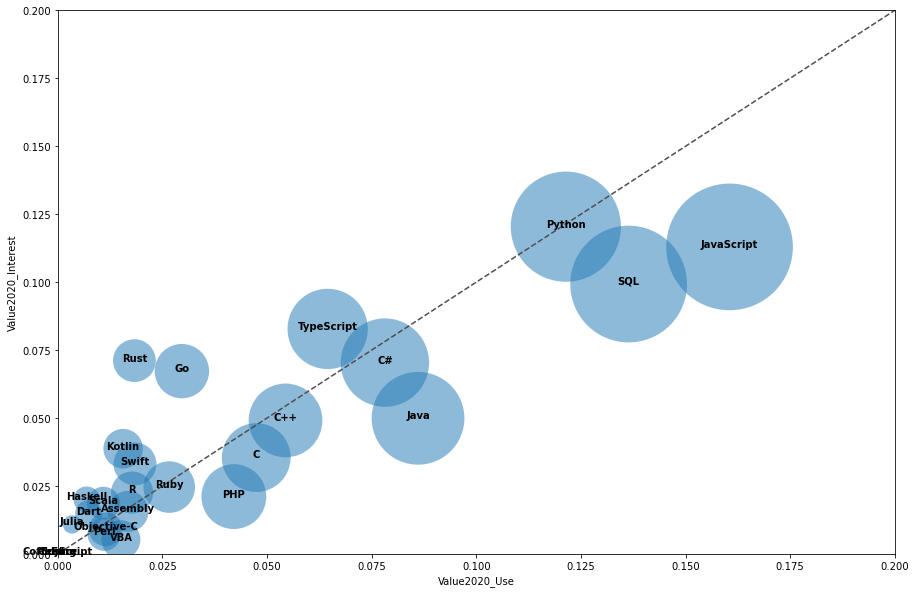

In [10]:
df = df_ct_used[['Rank2020','Value2020']].join(df_ct_interest[['Rank2020','Value2020']],lsuffix='_Use', rsuffix='_Interest')
df['Value2020']= df['Value2020_Use'] * 100000

#Create figure
plt.figure(figsize = (15,10))

# Create scatterplot. alpha controls the opacity and s controls the size.
ax = sns.scatterplot(df.Value2020_Use, df.Value2020_Interest, alpha = 0.5,s = df.Value2020)

ax.set_xlim(0,.20)
ax.set_ylim(0,.20)

#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
     ax.text(df.Value2020_Use[line], df.Value2020_Interest[line], df.index[line], 
             horizontalalignment='center', size='medium', color='black', weight='semibold')
        
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

Plotting relative use vs interest yields interesting results. Let's sacrifice some accuracy for readability by plotting ranks instead of values.

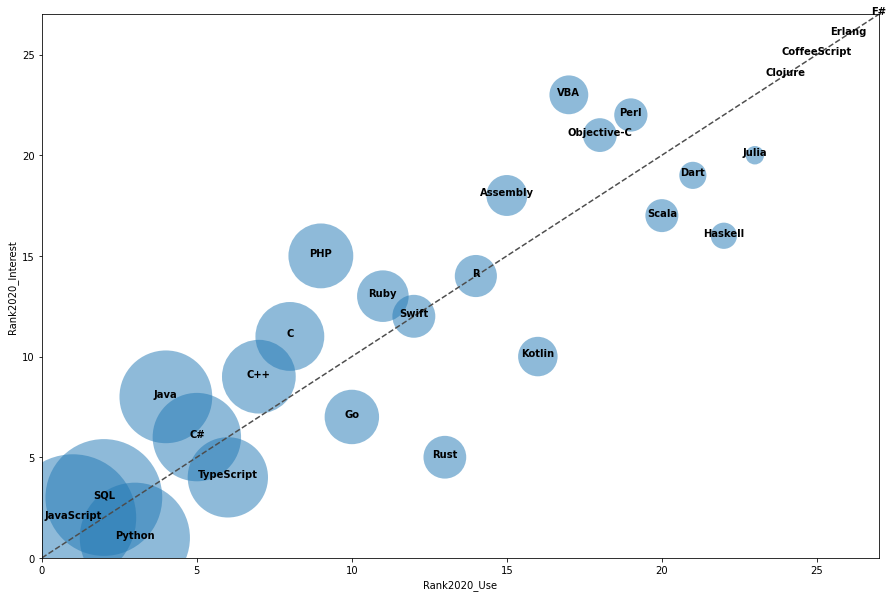

In [11]:
df = df_ct_used[['Rank2020','Value2020']].join(df_ct_interest['Rank2020'],lsuffix='_Use', rsuffix='_Interest')
df['Value2020']= df['Value2020']*100000

#Create figure
plt.figure(figsize = (15,10))

# Create scatterplot. alpha controls the opacity and s controls the size.
ax = sns.scatterplot(x=df.Rank2020_Use, y=df.Rank2020_Interest, alpha = 0.5,s = df.Value2020)

ax.set_xlim(0,27)
ax.set_ylim(0,27)

#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
     ax.text(df.Rank2020_Use[line], df.Rank2020_Interest[line], df.index[line], 
             horizontalalignment='center', size='medium', color='black', weight='semibold')
        
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

In [12]:
df = df_ct_used[['Rank2020','Value2020']].join(df_ct_interest[['Rank2020','Value2020']],lsuffix='_Use', rsuffix='_Interest')
df

Year,Rank2020_Use,Value2020_Use,Rank2020_Interest,Value2020_Interest
LanguageUsed,,,,
JavaScript,1.0,0.160499,2.0,0.112947
SQL,2.0,0.136387,3.0,0.099280
Python,3.0,0.121384,1.0,0.120390
Java,4.0,0.086061,8.0,0.049887
C#,5.0,0.078149,6.0,0.070380
TypeScript,6.0,0.064472,4.0,0.082768
C++,7.0,0.054399,9.0,0.049107
C,8.0,0.047404,11.0,0.035440
PHP,9.0,0.042057,15.0,0.021074


Upper left hand side of plot shows languages that are ranked higher in use than interest and vice-versa. Size of bubble indicates relative size of language by use. Using this we can put hype into perspective. The further away a language is from the diagnol line, the more extreme the hype vs use ratio. The sizing has some interessting implications as well. For example we can see that Java, C# an TypeScript have about the same number of users but th

Now we'll take a look at the languages at relationship between used languages and languages of interest.

<AxesSubplot:xlabel='LanguageInterest', ylabel='LanguageUsed'>

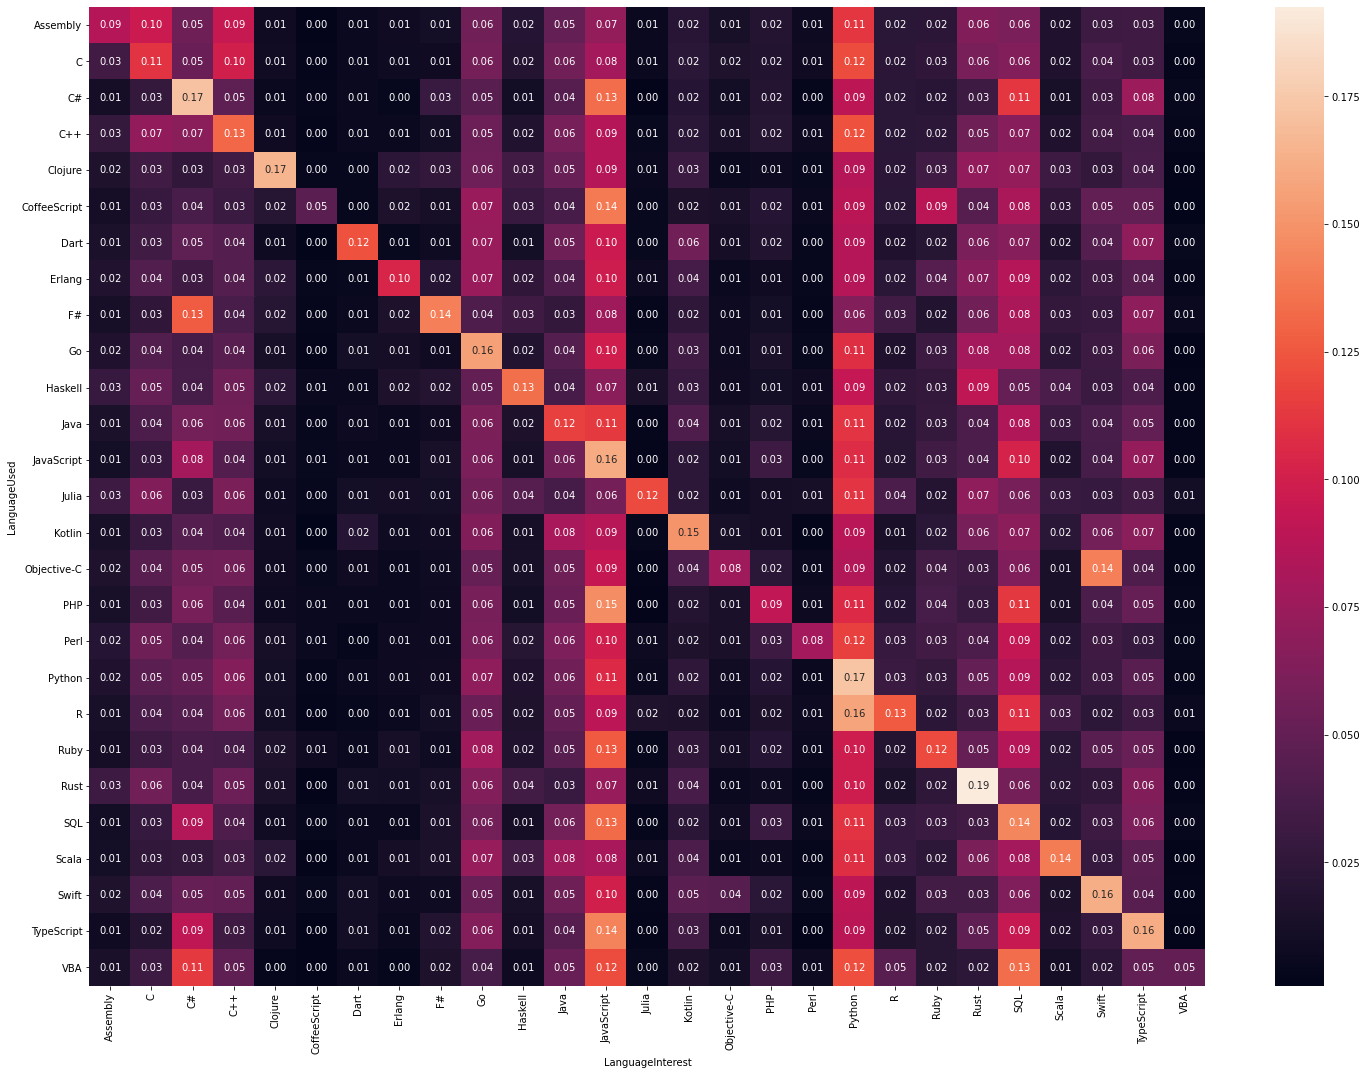

In [121]:
df = pd.crosstab(index=df_lang['LanguageUsed'], columns=df_lang['LanguageInterest'], normalize='index')

plt.figure(figsize=(25,18))
sns.heatmap(df,annot=True, fmt='.2f')

Write-up - Despite language used there is near universal interest in Python, Javascript, and to a lesser degree, SQL. Languages with stronger interest than another language than their own ex. R to Python. Create list for each language used of all interests that exceed or match used langauge.

### Association Analysis on Use

In [14]:
lang_used_basket = df_history[df_history['LanguageUsed'].notnull()]['LanguageUsed'].copy()
lang_used_basket = lang_used_basket.str.replace(' ','').str.split(';').tolist()

te = TransactionEncoder()
te_array = te.fit(lang_used_basket).transform(lang_used_basket)
df_basket = pd.DataFrame(te_array, columns=te.columns_)[lang_filter]
df_basket.head()

,Assembly,C,C#,C++,Clojure,CoffeeScript,Dart,Erlang,F#,Go,...,Perl,Python,R,Ruby,Rust,SQL,Scala,Swift,TypeScript,VBA
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
3,False,False,True,False,False,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [15]:
lang_int_basket = df_history[df_history['LanguageInterest'].notnull()]['LanguageInterest'].copy()
lang_int_basket = lang_int_basket.str.replace(' ','').str.split(';').tolist()

te = TransactionEncoder()
te_array = te.fit(lang_int_basket).transform(lang_int_basket)
df_basket = pd.DataFrame(te_array, columns=te.columns_)[lang_filter]
df_basket.head()

,Assembly,C,C#,C++,Clojure,CoffeeScript,Dart,Erlang,F#,Go,...,Perl,Python,R,Ruby,Rust,SQL,Scala,Swift,TypeScript,VBA
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
3,False,False,True,False,False,False,False,False,False,True,...,False,True,False,True,True,True,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


### Applying Apriori

In [16]:
df_freq_itemset = apriori(df_basket, min_support=0.05,use_colnames=True)
df_freq_itemset


,support,itemsets
0,0.137639,(C)
1,0.288820,(C#)
2,0.202144,(C++)
3,0.219384,(Go)
4,0.054334,(Haskell)
5,0.229823,(Java)
6,0.491543,(JavaScript)
7,0.088977,(Kotlin)
8,0.099951,(PHP)
9,0.448139,(Python)


### Mining Association Rules

In [17]:
df_rules = association_rules(df_freq_itemset, metric='confidence', min_threshold=.7)
df_rules.sort_values('confidence', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
7,"(SQL, PHP)",(JavaScript),0.066792,0.491543,0.056309,0.843041,1.715091,0.023477,3.239431
9,"(SQL, TypeScript)",(JavaScript),0.101362,0.491543,0.084478,0.833431,1.695539,0.034654,3.052529
0,(PHP),(JavaScript),0.099951,0.491543,0.078672,0.787104,1.601292,0.029542,2.388292
8,"(Python, TypeScript)",(JavaScript),0.091457,0.491543,0.070490,0.770742,1.568004,0.025535,2.217836
4,"(C#, TypeScript)",(JavaScript),0.092883,0.491543,0.070475,0.758753,1.543614,0.024819,2.107619
1,(TypeScript),(JavaScript),0.215390,0.491543,0.156735,0.727680,1.480399,0.050861,1.867130
3,"(C#, SQL)",(JavaScript),0.152206,0.491543,0.110390,0.725268,1.475492,0.035574,1.850739
5,"(SQL, Java)",(JavaScript),0.103604,0.491543,0.074321,0.717357,1.459397,0.023395,1.798936
6,"(JavaScript, PHP)",(SQL),0.078672,0.363468,0.056309,0.715742,1.969204,0.027714,2.239275
2,(R),(Python),0.093477,0.448139,0.065604,0.701827,1.566093,0.023714,1.850808


http://ethen8181.github.io/machine-learning/association_rule/apriori.html
https://medium.com/analytics-vidhya/association-analysis-in-python-2b955d0180c
http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/